In [2]:
from scipy.io import loadmat
import numpy as np
import mne
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from mne.viz import plot_topomap

In [78]:
# 1. Load the .mat file
data = loadmat('sampleEEGdata.mat')
EEG = data['EEG']
eeg_data = EEG['data'][0, 0] 
times = EEG['times'][0, 0][0] 
print('EEG.shape:', EEG.shape) 
print('eeg_data.shape:', eeg_data.shape) 
print('times.shape:', times.shape) 
microvolt = "µV"

# Time windows
time_window_pre = (-500, 0)
time_window_post = (100, 600)

# Find indices for the time windows
indices_pre = np.where((times >= time_window_pre[0]) & (times <= time_window_pre[1]))[0]
indices_post = np.where((times >= time_window_post[0]) & (times <= time_window_post[1]))[0]

# Extract data for the two time windows
eeg_data_epoch_b = eeg_data[:, indices_pre, :]
eeg_data_epoch_a = eeg_data[:, indices_post, :]

# Read the file content
with open('eloc64C2.txt', 'r') as f:
    lines = f.readlines()
# Extract channel names, theta, and radius
channel_names = [line.split()[3].replace('.', '') for line in lines[0:]]  # Skip the header
theta = np.array([float(line.split()[1])-90 for line in lines[0:]]) * np.pi / 180.0  # Convert to radians
radius = np.array([float(line.split()[2]) for line in lines[0:]])
# Convert polar to Cartesian
x = radius * np.cos(theta)/5
y = -radius * np.sin(theta)/5
z = np.zeros_like(x)  # default z-coordinate for all channels
# Create a montage
ch_pos = dict(zip(channel_names, zip(x, y, z)))
montage = mne.channels.make_dig_montage(ch_pos, coord_frame='head')
info = mne.create_info(ch_names=channel_names, sfreq=256, ch_types='eeg')
# Apply the montage to the info
info.set_montage(montage)
# mne.viz.plot_sensors(info, show_names=True)

EEG.shape: (1, 1)
eeg_data.shape: (64, 640, 99)
times.shape: (640,)


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Af7, Af3, F1, F3, F5, F7, Ft7, Fc5, Fc3, Fc1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 256.0 Hz
>

In [80]:
# Centering
centered_b= eeg_data_epoch_b - np.mean(eeg_data_epoch_b, axis=1, keepdims=True)
centered_a= eeg_data_epoch_a - np.mean(eeg_data_epoch_a, axis=1, keepdims=True)

# Initialize an array to hold the covariance matrices for each trial
cov_matrices_b = [np.cov(centered_b[:, :, trial]) for trial in range(centered_b.shape[2])] #rowvar=True
cov_matrices_a = [np.cov(centered_a[:, :, trial]) for trial in range(centered_a.shape[2])] #rowvar=True

# Get the average of the covariance matrices over all the trials
avg_cov_matrix_b= np.mean(cov_matrices_b, axis=0)
avg_cov_matrix_a= np.mean(cov_matrices_a, axis=0)

# Perform eigenvalue decomposition
eigenvalues_b, eigenvectors_b = eigh(avg_cov_matrix_b)
eigenvalues_a, eigenvectors_a = eigh(avg_cov_matrix_a)

# Sort the eigenvalues and eigenvectors in descending order
sorted_indices_b = np.argsort(eigenvalues_b)[::-1]
eigenvalues_sorted_b = eigenvalues_b[sorted_indices_b]
eigenvectors_sorted_b = eigenvectors_b[:, sorted_indices_b]

# Sort the eigenvalues and eigenvectors in descending order
sorted_indices_a = np.argsort(eigenvalues_a)[::-1]
eigenvalues_sorted_a = eigenvalues_a[sorted_indices_a]
eigenvectors_sorted_a= eigenvectors_a[:, sorted_indices_a]

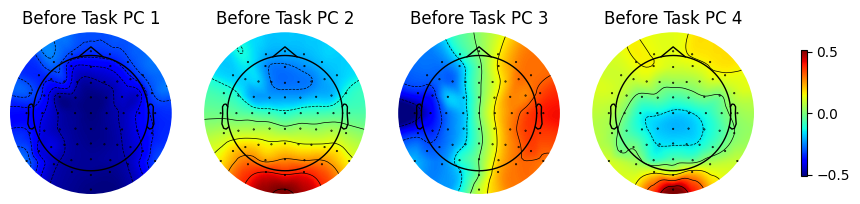

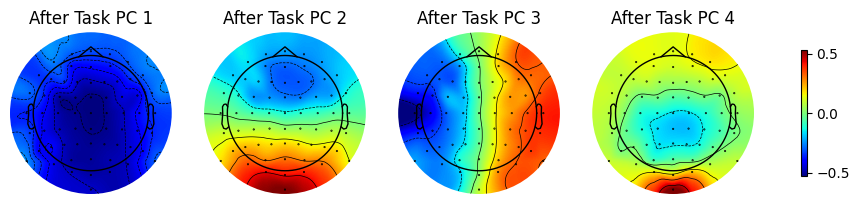

In [82]:
# Function to plot topographical maps for the first four components
def plot_topographical_maps(pcs, info, title):
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))  # Create a row of 4 subplots
    for i, ax in enumerate(axes):
        im, _ = plot_topomap(pcs[:, i], info, axes=ax, cmap='jet', show=False)
        ax.set_title(f'{title} PC {i+1}')
    fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)
    plt.show()

plot_topographical_maps(eigenvectors_sorted_b, info, "Before Task")
plot_topographical_maps(eigenvectors_sorted_a, info, "After Task")


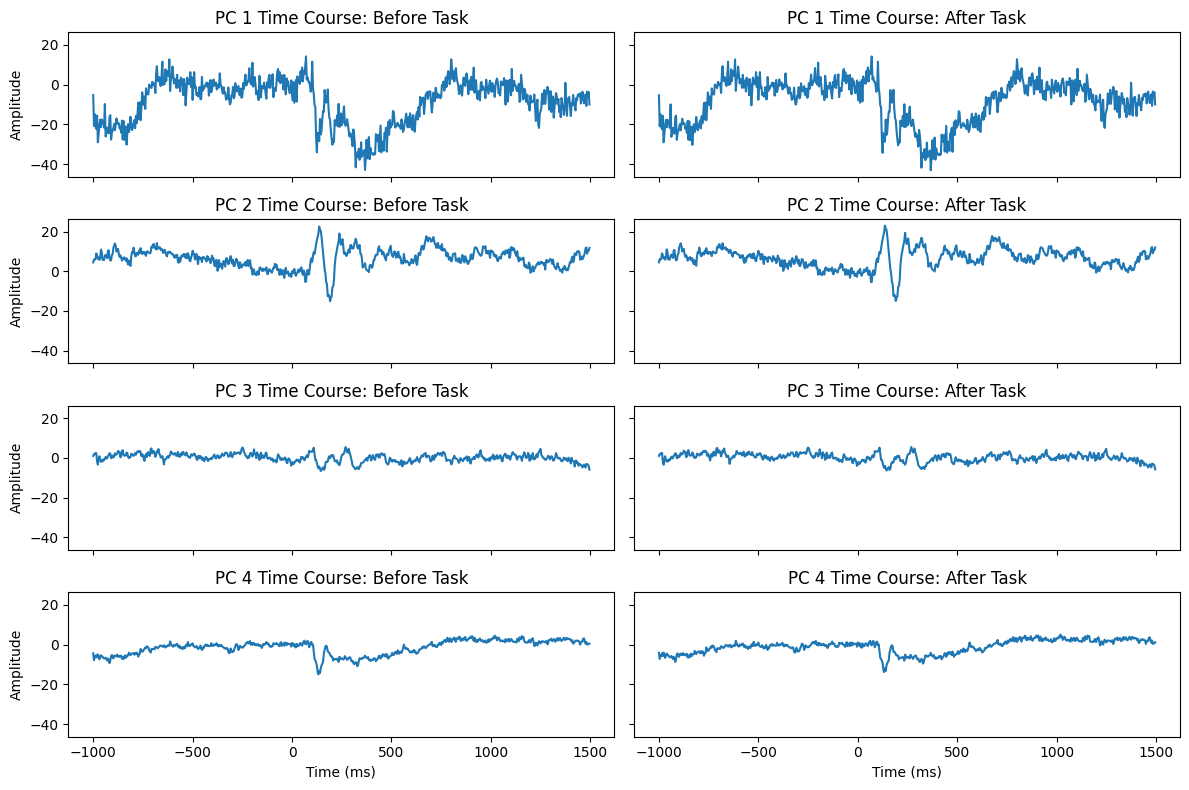

In [86]:
# Function to calculate and plot the time courses for the first four components before and after the task
def plot_time_courses(eigenvectors_sorted_b, eigenvectors_sorted_a, eeg_data, times):
    fig, axes = plt.subplots(4, 2, figsize=(12, 8), sharex=True, sharey=True)  # 4 components, 2 conditions
    for i in range(4):  # First four components
        # Before task
        pca_time_course_b = np.tensordot(eeg_data, eigenvectors_sorted_b[:, i], axes=(0, 0))
        pca_time_course_b = np.mean(pca_time_course_b, axis=1)
        axes[i, 0].plot(times, pca_time_course_b, label='Before Task')
        axes[i, 0].set_title(f'PC {i+1} Time Course: Before Task')
        # After task
        pca_time_course_a = np.tensordot(eeg_data, eigenvectors_sorted_a[:, i], axes=(0, 0))
        pca_time_course_a = np.mean(pca_time_course_a, axis=1)
        axes[i, 1].plot(times, pca_time_course_a, label='After Task')
        axes[i, 1].set_title(f'PC {i+1} Time Course: After Task')

    axes[-1, 0].set_xlabel('Time (ms)')
    axes[-1, 1].set_xlabel('Time (ms)')
    axes[0, 0].set_ylabel('Amplitude')
    axes[1, 0].set_ylabel('Amplitude')
    axes[2, 0].set_ylabel('Amplitude')
    axes[3, 0].set_ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

# Plot topographical maps and time courses for the first four components before and after the task
plot_time_courses(eigenvectors_sorted_b, eigenvectors_sorted_a, eeg_data, times)

Topographical Maps


Before Task: The topographical maps before the task show the spatial distribution of the EEG activity associated with each of the first four principal components. Each map seems to highlight different areas of the scalp, suggesting that each component represents a different spatial pattern of brain activity.

After Task: The maps after the task show how the spatial patterns have changed. There may be shifts in the intensity and location of the activity.



Time Courses
Before Task: The time courses before the task show the temporal dynamics of each component's activity leading up to the task. They seem to have varying degrees of fluctuation, with some components showing more pronounced changes in amplitude over time.


After Task: The time courses after the task show how the activity evolves over time in response to the task. There may be changes in the amplitude or variability of the signal.


Interpretations

Differences: If the topographical maps and time courses show clear differences before and after the stimulus onset, this could indicate that the task has an effect on brain activity. The nature of the differences could suggest which areas of the brain are more engaged or disengaged due to the task.

Similarities: Similar patterns before and after the stimulus might suggest stable, ongoing brain processes that are not specifically modulated by the task or are part of a baseline activity pattern that persists throughout.


Before vs. After Task: I expect to see differences in the EEG patterns when comparing the period before and after the task onset. A lack of change might suggest that the task did not elicit a strong neural response, or that the components captured by PCA are not sensitive to the task.


For a more precise interpretation, it is crucial to consider the broader context, including the experimental design, the hypotheses, individual differences among participants, and the specific cognitive processes that the task is designed to engage. It's also important to consider that PCA components are a mixture of all the signals present in the EEG, including possible artifacts, so careful preprocessing and interpretation are critical.